In [1]:
import os 
import glob
import json
import numpy as np
import cv2

In [2]:
train_path = "train"
valid_path = "valid"

In [3]:
train_data=[image for image in os.listdir(train_path)]


In [4]:
with open('train/_annotations.coco.json','r') as file:
    data = json.load(file)

for img in data['annotations'][:10]:
    print(img['bbox'])

[145, 239, 168.75, 162.5]
[194, 176, 148.75, 233.75]
[133, 173, 162.5, 185]
[245, 358, 138.75, 166.25]
[80, 189, 112.5, 132.5]
[293, 150, 182.5, 135]
[199, 165, 171.25, 133.75]
[350, 288, 42.5, 52.5]
[239, 250, 61.25, 87.5]
[73, 139, 206.25, 166.25]


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_annotations(ax, image, annotations, display_type='both', colors=None):
    ax.imshow(image)
    ax.axis('off')  # Turn off the axes

    # Define a default color map if none is provided
    if colors is None:
        colors = plt.cm.tab10

    for ann in annotations:
        category_id = ann['category_id']
        color = colors(category_id % 10)
        
        # Display bounding box
        if display_type in ['bbox', 'both']:
            bbox = ann['bbox']  # COCO format: [x_min, y_min, width, height]
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
        
        # Display segmentation polygon
        if display_type in ['seg', 'both']:
            for seg in ann['segmentation']:
                poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                polygon = patches.Polygon(poly, closed=True, edgecolor=color, fill=False)
                ax.add_patch(polygon)

def display_images_with_coco_annotations(image_paths, annotations, display_type='both', colors=None):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        
        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
        
        display_image_with_annotations(ax, image, img_annotations, display_type, colors)

    plt.tight_layout()
    plt.show()

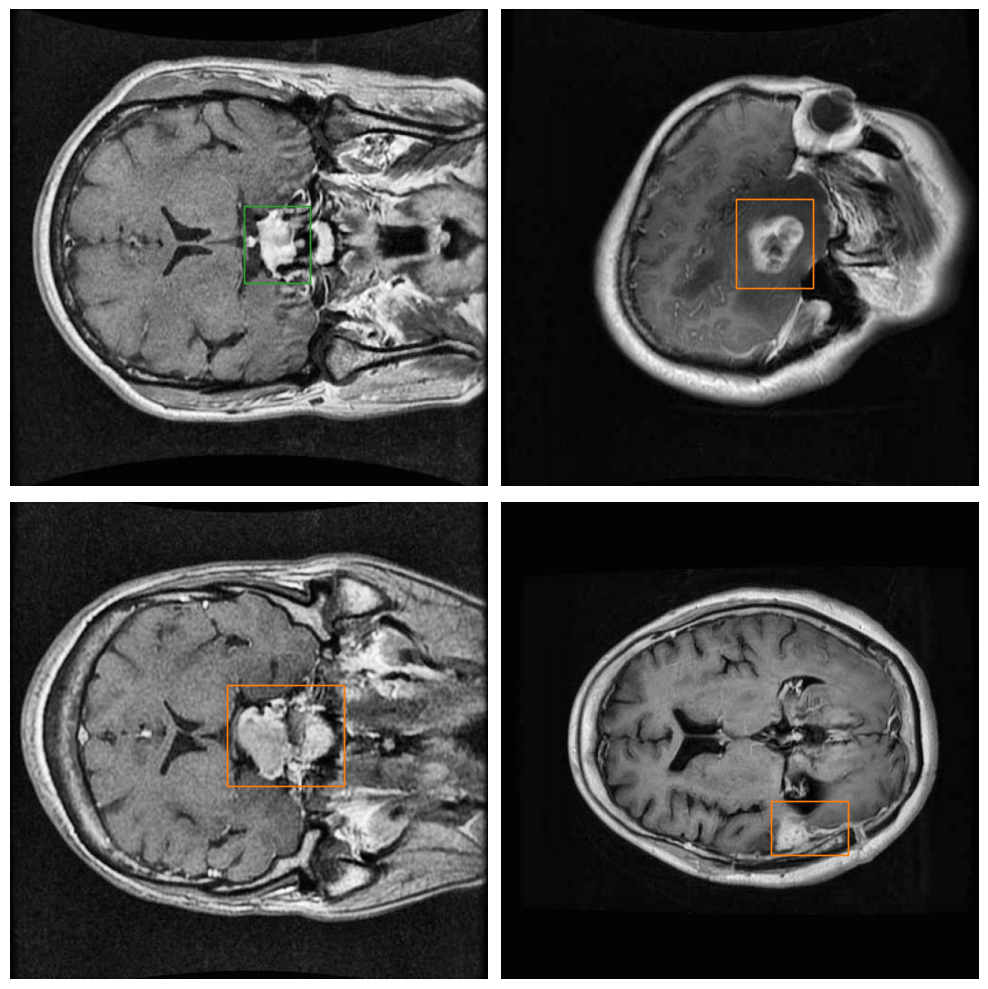

In [6]:
import random 
with open('train/_annotations.coco.json','r') as file:
    annotations = json.load(file)

# Get all image files   
image_dir = train_path
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'both'
display_images_with_coco_annotations(random_image_files, annotations, display_type)

In [7]:
# print the overall structure
def print_structure (d, indent=0):
    if isinstance(d,dict):
        for key , value in d.items():
            print(' ' * indent + str(key))
            print_structure(value,indent+1)
    elif isinstance(d, list):
        print(' ' * indent + "list of length {} containing : ".format(len(d)))
        if d:
            print_structure(d[0],indent+1) # only print the structure of the first item

with open('train/_annotations.coco.json','r') as file:
    data = json.load(file)


print_structure(data)

info
 year
 version
 description
 contributor
 url
 date_created
licenses
 list of length 1 containing : 
  id
  url
  name
categories
 list of length 3 containing : 
  id
  name
  supercategory
images
 list of length 1502 containing : 
  id
  license
  file_name
  height
  width
  date_captured
annotations
 list of length 1502 containing : 
  id
  image_id
  category_id
  bbox
   list of length 4 containing : 
  area
  segmentation
   list of length 1 containing : 
    list of length 10 containing : 
  iscrowd


In [8]:
import json
import numpy as np
import skimage.draw
import tifffile
import os
import shutil
import matplotlib.pyplot as plt

def create_mask(image_info, annotations, output_folder, max_print=3):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
#     print(mask_np.shape)

    # Counter for the object number
    object_number = 1

    printed_masks = 0  # Counter for the number of printed masks

    for ann in annotations:
        if ann['image_id'] == image_info['id']:
#             print(f"Processing annotation for image {image_info['file_name']}: {ann}")
            # Extract segmentation polygon
            for seg_idx, seg in enumerate(ann['segmentation']):
#                 print(f"Segmentation points: {seg}")
                # Convert polygons to a binary mask and add it to the main mask
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                # Create a mask for each segmentation
                seg_mask = np.zeros_like(mask_np, dtype=np.uint8)
                seg_mask[rr, cc] = 255  # Set the pixel values to 255 for the polygon
                # Save the segmentation mask
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
#                 print(f"Saved segmentation mask for {image_info['file_name']} segment {seg_idx} to {mask_path}")
                
                # Print the segmentation mask using imshow
                # plt.imshow(seg_mask, cmap='gray')
                # plt.title(f"Segmentation Mask for {image_info['file_name']} Segment {seg_idx}")
                # plt.show()
                
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if maximum number of masks to print is reached

#     print("All segmentation masks saved.")

In [9]:
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
    
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)
#         print(f"Copied original image to {new_image_path}")

In [10]:
# Only train and val 

original_image_dir = 'train'  # Where your original images are stored
json_file = 'train/_annotations.coco.json'
mask_output_folder = 'train2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = 'train2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = 'valid'  # Where your original images are stored
json_file = 'valid/_annotations.coco.json'
mask_output_folder = 'valid2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = 'valid2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

"I found a problem within train dataser .. there's an image that doesnt have a corresponding mask so im making a function to search and grab that file and delete it"

In [11]:
import os

def compare_folders_and_delete(folder1_path, folder2_path):
    folder1_items = os.listdir(folder1_path)
    folder2_items = os.listdir(folder2_path)

    for item1 in folder1_items:
        found = False
        for item2 in folder2_items:
            if item1[:4] == item2[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item1} not found.")
            item1_path = os.path.join(folder1_path, item1)
            os.remove(item1_path)
            print(f"Deleted {item1}")

    for item2 in folder2_items:
        found = False
        for item1 in folder1_items:
            if item2[:4] == item1[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item2} not found.")
            item2_path = os.path.join(folder2_path, item2)
            os.remove(item2_path)
            print(f"Deleted {item2}")

# Example usage:
folder1_path = "train2/images"
folder2_path = "train2/masks"
compare_folders_and_delete(folder1_path, folder2_path)

Corresponding item for 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg not found.
Deleted 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg


BEHÖVS DENNA?!?!? VI HAR EN TILL DÄR NERE?!?

In [12]:
import os
import cv2
import numpy as np

class CustomDataset:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read corresponding mask
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        return image, mask

# Example usage:
dataset = CustomDataset(r"train2") 
image, mask = dataset[0]
print(image.shape, mask.shape)
# plt.imshow(image) #, plt.imshow(mask)

(640, 640, 3) (640, 640)


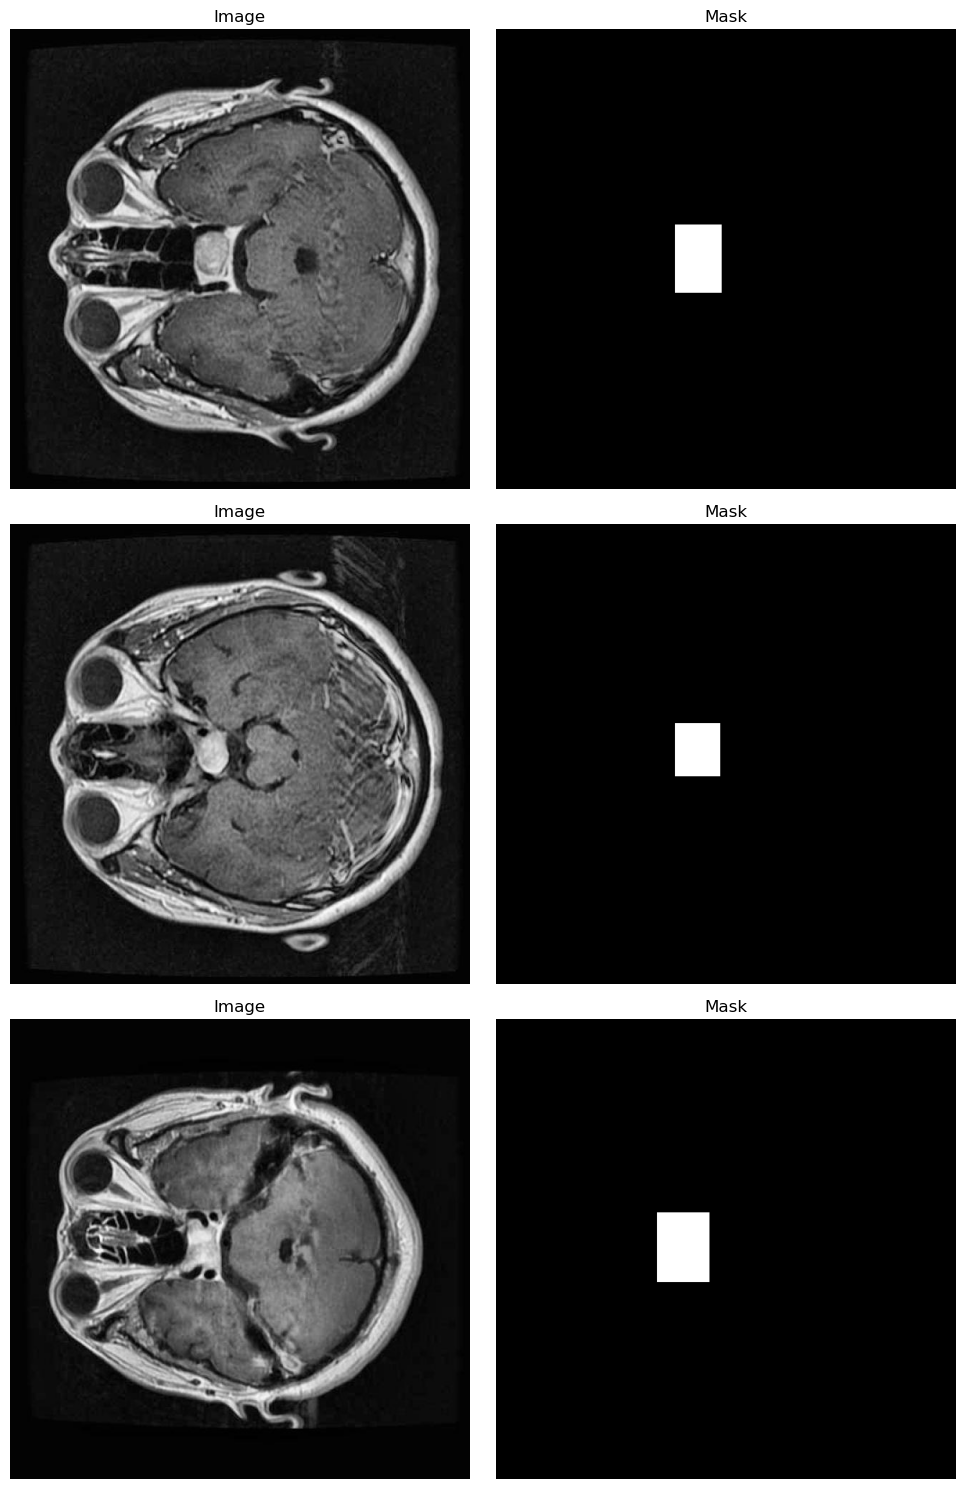

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):  # Plot the first three samples
    image, mask = dataset[i]
    axs[i, 0].imshow(image)
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title('Mask')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset_general(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale

        # Read corresponding mask
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)

        return image_gray, mask

# Define paths for train, validation, and test sets
train_path = "train2" 
valid_path = "valid2"
# test_path = "/kaggle/working/test2"

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Create datasets
train_dataset = CustomDataset_general(train_path, transform=image_transform)
valid_dataset = CustomDataset_general(valid_path, transform=image_transform)
# test_dataset = CustomDataset_general(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
x, y = next(iter(train_loader))
x.shape , y.shape , type(x) , type(y)

(torch.Size([32, 1, 224, 224]),
 torch.Size([32, 1, 224, 224]),
 torch.Tensor,
 torch.Tensor)

In [16]:
# lets take a look at the data inside dataloaders and make sure it within range of [0,1] 
# because we're using binary cross entropy so out data needs to be within that range 

# Assuming x is a tensor from your DataLoader
# x, y = next(iter(train_loader))
import torch
# Count number of ones and zeros in tensor x
num_ones = torch.eq(x, 1).sum().item()
num_zeros = x.numel() - num_ones

print("Number of ones in x:", num_ones)
print("Number of zeros in x:", num_zeros)

# Count number of ones and zeros in tensor y
num_ones = torch.eq(y, 1).sum().item()
num_zeros = y.numel() - num_ones

print("Number of ones in y:", num_ones)
print("Number of zeros in y:", num_zeros)

Number of ones in x: 60097
Number of zeros in x: 1545535
Number of ones in y: 44466
Number of zeros in y: 1561166


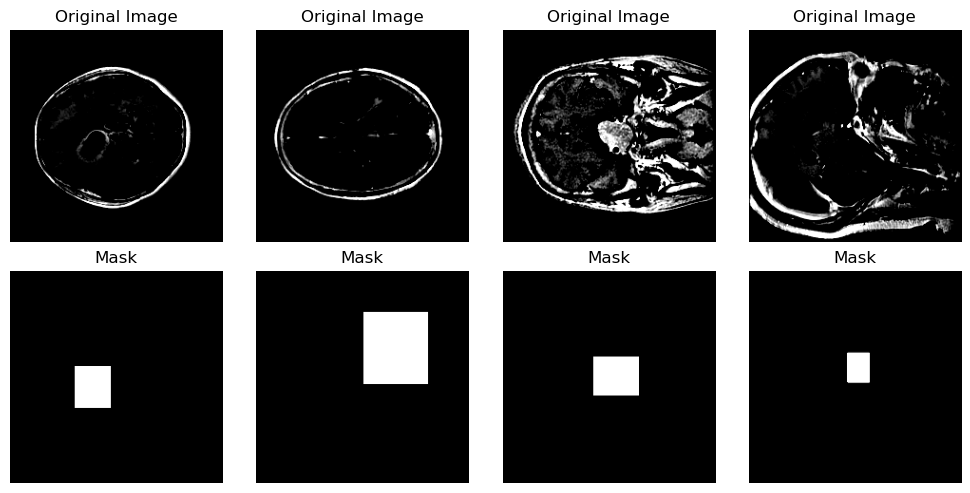

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to numpy arrays and squeeze the channel dimension
x_np = x.numpy().squeeze(1)
y_np = y.numpy().squeeze(1)

# Plot the images
plt.figure(figsize=(10, 5))

# Plot original images
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_np[i], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

# Plot masks
for i in range(4):
    plt.subplot(2, 4, i + 5)
    plt.imshow(y_np[i], cmap='gray')
    plt.title('Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
import torch
from torch import nn

C = 1 #How many channels are in the input? 
n_filters = 32 #Smallest value of filters you should usually consider. If we wanted to try and optimize the architecture we could use Optuna to pick a better number of filters. 
loss_func = nn.BCEWithLogitsLoss() #BCE loss implicitly assumes a binary problem

#Define our helper function that creates a hidden layer for a CNN
def cnnLayer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer
    out_filters: how many channels should this layer output
    kernel_size: how large should the filters of this layer be
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
    )
#Specifying a model for image segmentation
model = nn.Sequential(
    cnnLayer(C, n_filters), #First layer changes number of channels up to the large numer
    *[cnnLayer(n_filters, n_filters) for _ in range(5)], #Create 5 more hidden layers
    #Make a prediction for _every_ location. Notice we use 1 channel out, since we have a binary problem and are using BCEWithLogitsLoss as our loss function. 
    nn.Conv2d(n_filters, 1, (3,3), padding=1), #Shape is now (1, W, H)
)

In [19]:
# loss fun and optimizer
from torch.optim import lr_scheduler
import torch 
from torch import nn
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)


In [20]:
# make our early stopping class
class EarlyStopping:
  def __init__(self,patience:int=10,delta:float=0.001,path='best_model.pth'):
    self.patience = patience
    self.delta = delta
    self.path = path
    self.best_score = None
    self.early_stop = False
    self.counter = 0

  def __call__(self,val_loss , model):
    if self.best_score is None:
      self.best_score = val_loss
      self.save_checkpoint(model)

    elif val_loss > self.best_score + self.delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True

    else:
      self.best_score = val_loss
      self.save_checkpoint(model)
      self.counter = 0

  def save_checkpoint(self,model):
    torch.save(model.state_dict(),self.path)

early_stopping = EarlyStopping(patience = 10,delta = 0.)

In [21]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device='cpu'):
  model.train()

  train_loss = 0
  train_accuracy = 0

  for batch, (X,y) in enumerate(dataloader):
    X = X.to(device,dtype=torch.float32)
    y = y.to(device,dtype=torch.float32) # dtype of the target y to torch.long assuming it represents class indices. This is the appropriate datatype for class labels.

    optimizer.zero_grad()

    y_pred_logits = model(X)

    loss= loss_fn(y_pred_logits,y)

    train_loss += loss.item()

    loss.backward()
    optimizer.step()

    # y_pred_prob = y_pred_logits.softmax(dim=1) # turn predictions intp probability distribution
    # y_pred_target = y_pred_prob.argmax(dim=1) # take the biggest index in the prob. dist. .. this is out right class ex: [0] -> fresh strawberry

    # print(f'this is true label : {y}')
    # print(f'this is predicted label : {y_pred_target}')

    # train_accuracy += balanced_accuracy_score(y.cpu().numpy(),y_pred_target.detach().cpu().numpy(),adjusted=True)


  lr_scheduler.step()

  train_loss = train_loss / len(dataloader)
  # train_accuracy = train_accuracy / len(dataloader)

  return train_loss  , train_accuracy

In [22]:
def val_step(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             device='cpu'):

  model.eval()

  val_loss = 0
  val_accuracy = 0

  with torch.inference_mode():
    for batch , (X,y) in enumerate (dataloader):
      X = X.to(device,dtype=torch.flaot32)
      y = y.to(device,dtype=torch.float32)

      y_pred_logits = model(X)

      loss = loss_fn(y_pred_logits,y)
      va_loss += loss.item()

      # y_pred_prob = y_pred_logits.softmax(dim=1)
      # y_pred_target = y_pred_prob.argmax(dim=1)

      # val_accuracy += balanced_accuracy_score(y.cpu().numpy(),y_pred_target.detach().cpu().numpy(),adjusted=True)

  val_loss = val_loss / len(dataloader)
  # val_accuracy = val_accuracy / len(dataloader)

  return val_loss , val_accuracy

In [23]:
from tqdm.notebook import tqdm

def Train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          val_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          early_stopping,epochs:int=10,
          device='cpu'):
  results = {
      'train_loss' : [],
      'train_accuracy' : [],
      'val_loss' : [],
      'val_accuracy' : []
  }
  for epoch in tqdm(range(epochs)):

    train_loss , train_accuracy = train_step(model=model,
                                             dataloader=train_dataloader,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer,
                                             device=device)

    val_loss , val_accuracy = train_step(model=model,
                                             dataloader=val_dataloader,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer,
                                             device=device)
    print(f'Epoch : {epoch+1} | train loss : {train_loss:.4f} | train accuracy : {train_accuracy:.4f} | val loss : {val_loss:.4f} | val accuracy : {val_accuracy:.4f}')

    early_stopping(val_loss,model)

    if early_stopping.early_stop == True:
      print('Early stopping')
      break

    results['train_loss'].append(train_loss)
    results['train_accuracy'].append(train_accuracy)
    results['val_loss'].append(val_loss)
    results['val_accuracy'].append(val_accuracy)

  return results

In [24]:
def manual_seed(seed):
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

In [25]:
epochs = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = Train(model.to(device),
                train_dataloader=train_loader,
                val_dataloader=valid_loader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                early_stopping=early_stopping,
                device=device,
                epochs=epochs)

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# We define a function to visualize the evolution of the loss and the metric.
def loss_and_metric_plot(results:dict):

    plt.style.use('ggplot')
    training_loss = results['train_loss']
    # training_metric = results['train_accuracy']

    validation_loss = results['val_loss']
    # validation_metric = results['val_accuracy']

    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3.8))
    ax = ax.flat

    ax[0].plot(training_loss, 'o-', markersize = 4, label = "Train")
    ax[0].plot(validation_loss, label = "Val")
    ax[0].set_title("BinaryLoss", fontsize = 12, fontweight = "bold", color = "black")
    ax[0].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[0].set_ylabel("loss", fontsize = 10, fontweight = "bold", color = "black")

    ax[0].legend()
    fig.show()